# Song Recommendations

In this notebook, we will use a collection of datasets referred to as the Million Song Dataset (MSD),
a project initiated by The Echo Nest and LabROSA. The Echo Nest was a research spin-off from the
MIT Media Lab established with the goal of understanding the audio and textual content of recorded
music, and was acquired by Spotify after 10 years for 50 million Euro. 

In this notebook we will use the Taste Profile dataset from the Million Song Dataset (MSD), a project 
initiated by The Echo Nest and LabROSA, to develop a song recommendation system based on collaborative 
filtering.

Collaborative filtering describes algorithms that generate songs recommendations for specific users
based on the combined user-song play information from all users. These song recommendations are
generated by embedding users and songs as numerical vectors in the same vector space, and selecting
songs that are similar to the user based on cosine similarity.

In [1]:
# Function to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


In [ ]:
# Start Spark
start_spark(executor_instances=4, executor_cores=4, worker_memory=4, master_memory=4)

In [3]:
# Import 
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.functions import regexp_replace, sum, col, row_number, rand, udf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.recommendation import ALS


# Other imports to be used locally
import os, sys
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from itertools import chain
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib notebook

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])

name = "hng38"

# Determine ideal number of partitions
conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 64


In [4]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

## Data processing

In [13]:
# triplets schema
schema_triplets = StructType([
    StructField("userID", StringType(), True),
    StructField("songID", StringType(), True),
    StructField("playCount", IntegerType(), True),
])


# load triplets from HDFS
triplets = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(schema_triplets)
    .load("/data/msd/tasteprofile/triplets.tsv")
    .repartition(partitions)
)
triplets.cache()
print(f'{triplets.count()} rows -- triplets.tsv')

48373586 rows -- triplets.tsv


In [16]:
# load manually accepted IDs
manually_accepted = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
manually_accepted = manually_accepted.filter(F.col('value').contains('ERROR'))
manuacceptedIDs = manually_accepted.select(manually_accepted.value.substr(11,18).alias('songID'))

show_as_html(manuacceptedIDs,5)

,songID
0,SOFQHZM12A8C142342
1,SODXUTF12AB018A3DA
2,SOASCRF12A8C1372E6
3,SOITDUN12A58A7AACA
4,SOLZXUM12AB018BE39


In [17]:
#load mismatch IDs
mismatch_file = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
mismatchIDs = mismatch_file.select(mismatch_file.value.substr(9,18).alias('songID'))

show_as_html(mismatchIDs,5)

,songID
0,SOUMNSI12AB0182807
1,SOCMRBE12AB018C546
2,SOLPHZY12AC468ABA8
3,SONGHTM12A8C1374EF
4,SONGXCA12A8C13E82E


In [18]:
# remove manually accepted IDs from mismatchID by left anti join

mismatchIDs = (
    mismatchIDs
        .join(
            manuacceptedIDs,
            on = 'songID',
            how = 'leftanti') 
            )

# remove mismatch IDs from triplets by left anti join
cleanTriplets = (
    triplets
        .join(
            mismatchIDs,
            on = 'songID',
            how = 'leftanti') 
            )

show_as_html(cleanTriplets,5)
cleanTriplets.cache()

,songID,userID,playCount
0,SOOLGWZ12A67ADCD68,a099fbf40c6b4b9aa78f06cd37033a2e2055a831,9
1,SOOWYMT12AC4688E6A,f8434e514fba0d133665bf7a11fb59063840e211,1
2,SOHCUMK12A8C14078A,d928fde11641a42e7331d4425ce9950546f1abb4,2
3,SOPYCMI12AB01849DF,22d6f5ea8100997b1af59c6b79728fc2fc5c573a,2
4,SODPCWJ12AB017FE82,0397bc415902cc4fa503a8670083891ee04dc70a,2


DataFrame[songID: string, userID: string, playCount: int]

In [19]:
cleanTriplets.count()

45795111

## Song Recommendations


In [73]:
cfData = cleanTriplets
cfData.cache()
show_as_html(cfData)

,songID,userID,playCount
0,SOOLGWZ12A67ADCD68,a099fbf40c6b4b9aa78f06cd37033a2e2055a831,9
1,SOOWYMT12AC4688E6A,f8434e514fba0d133665bf7a11fb59063840e211,1
2,SOHCUMK12A8C14078A,d928fde11641a42e7331d4425ce9950546f1abb4,2
3,SOPYCMI12AB01849DF,22d6f5ea8100997b1af59c6b79728fc2fc5c573a,2
4,SODPCWJ12AB017FE82,0397bc415902cc4fa503a8670083891ee04dc70a,2
5,SOYUPVH12A6310DBBF,40de2e173499cf1a0d6a474bd18d21a9f20f5b62,1
6,SOYGKNI12AB0187E6E,b5230a5c791e82a7e3a4399641949e1ae08ce5bc,14
7,SODQRHM12A6D4FA611,d3a28afade754be27e9225a42bb4de864c755ebc,5
8,SOHZPIK12A58A7CCAE,bd98c68725ea9900966bb6480fbfe9baf25322bf,5
9,SOXQYSC12A6310E908,f80063049758ca731308fb5886fb1328b4aad9eb,3


In [74]:
cfData.count()

45795111

In [75]:
#Number of unique songs in the dataset

uniqueSong = int((cfData.select(F.countDistinct('songID'))).collect()[0][0])
print(f'Number of unique songs in the dataset: {uniqueSong}')

Number of unique songs in the dataset: 378310


In [76]:
#Number of unique users in the dataset

uniqueUser = int((cfData.select(F.countDistinct('userID'))).collect()[0][0])
print(f'Number of unique users in the dataset: {uniqueUser}')

Number of unique users in the dataset: 1019318


The number of unique songs in the dataset is 378,310 while the number of unique users is 1,019,318.

In [77]:
# Number of different songs has the most active user played

NoSongPlayed = (
    cfData
        .groupBy('userID')
        .agg(
            F.countDistinct('songID').alias('songCount')
        )
        .sort(F.col('songCount').desc())
)
show_as_html(NoSongPlayed,10)
print(f'Number of different songs has the most active user played: {NoSongPlayed.collect()[0][1]}')

,userID,songCount
0,ec6dfcf19485cb011e0b22637075037aae34cf26,4316
1,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc,1562
2,5a3417a1955d9136413e0d293cd36497f5e00238,1557
3,fef771ab021c200187a419f5e55311390f850a50,1545
4,c1255748c06ee3f6440c51c439446886c7807095,1498
5,4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f,1470
6,cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6,1457
7,96f7b4f800cafef33eae71a6bc44f7139f63cd7a,1407
8,b7c24f770be6b802805ac0e2106624a517643c17,1364
9,119b7c88d58d0c6eb051365c103da5caf817bea6,1362


Number of different songs has the most active user played: 4316


This most active user may use the account for café of store background music, and keeping this user may cause some noise in our recommendation model.

In [78]:
# percentage of the total number of unique songs in the dataset
print(f'Percentage of the number of unique songs played by most active user: {((NoSongPlayed.collect()[0][1])/uniqueSong)*100:.2f}%')

Percentage of the number of unique songs played by most active user: 1.14%


To calculate the number of different songs that have most active user played, we first group the dataset by userID, then count distinct SongID. The playCount was not computed as the high playCount may be the result of repeating one song many times. The most active user played 4,316 unique songs, which accounts for 1.14% of whole unique songs in our dataset.

In [79]:
# Percentage of the total number of songs only play by one user
unqSongPlayed =(
    cfData
        .groupBy('songID')
        .agg(
            F.countDistinct('userID').alias('NoUsersPlayed')
        )
        .sort(F.col('NoUsersPlayed').asc())
                    )
show_as_html(unqSongPlayed)

#Percentage of song that only played by one user
precentUnqSong = float(unqSongPlayed.filter(unqSongPlayed.NoUsersPlayed ==1).count()/uniqueSong*100)
print(f'Percentage of the total number of unique songs in the dataset: {precentUnqSong:.2f}%')

,songID,NoUsersPlayed
0,SOEOYIO12A8C1391FC,1
1,SOMHKZX12A8C13ACFE,1
2,SOVIJHG12AB0180793,1
3,SOBUPCE12A8AE475C6,1
4,SOLGTBM12A8C1396DC,1
5,SOMIOCB12AB01823B1,1
6,SOTCWDM12AB0186834,1
7,SOVGNIV12A6310F0D3,1
8,SOVSDFS12A8C135481,1
9,SOLCKCW12A8C14040C,1


Percentage of the total number of unique songs in the dataset: 8.32%


We visualize the distribution of song popularity in 2 charts. One limited to the popularity up to 500 users, and another provide the overview.

Text(0,0.5,'Number of Songs')

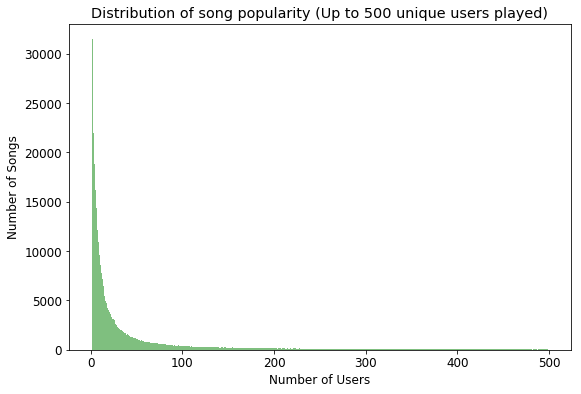

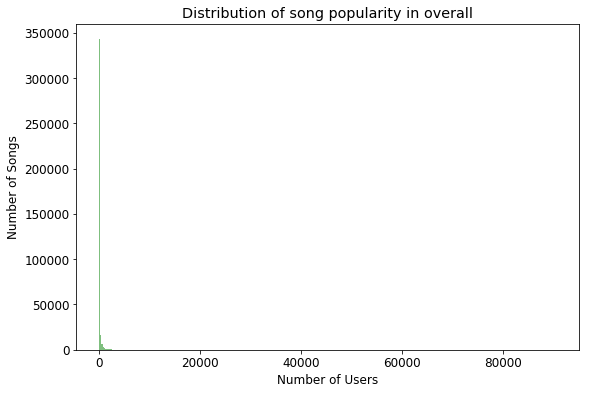

In [80]:
# Visualize the distribution of song popularity

songPopuPD = (
    unqSongPlayed
        .toPandas()
            )

binRange =range(1,500, 1)
plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
songPopuPD['NoUsersPlayed'].plot.hist(bins=binRange, alpha=0.5, color='green', edgecolor='none')
plt.title('Distribution of song popularity (Up to 500 unique users played)')
plt.xlabel('Number of Users')
plt.ylabel('Number of Songs')

plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
songPopuPD['NoUsersPlayed'].plot.hist(bins=400, alpha=0.5, color='green', edgecolor='none')
plt.title('Distribution of song popularity in overall')
plt.xlabel('Number of Users')
plt.ylabel('Number of Songs')

The visualization of the distribution of user activity also presents into 2 charts, one is up 500 unique songs played, and the other shows overall distribution.

Text(0,0.5,'Number of Users')

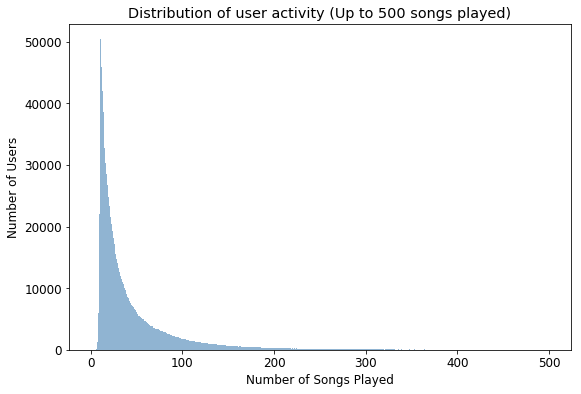

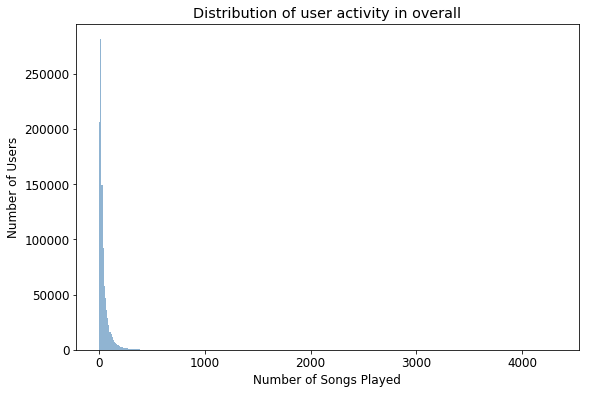

In [81]:
# Visualize the distribution of user activity

userActvPD = (
    NoSongPlayed
        .toPandas()
)

plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
userActvPD['songCount'].plot.hist(bins=binRange, alpha=0.6, color='steelblue', edgecolor='none')
plt.title('Distribution of user activity (Up to 500 songs played)')
plt.xlabel('Number of Songs Played')
plt.ylabel('Number of Users')

plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
userActvPD['songCount'].plot.hist(bins=400, alpha=0.6, color='steelblue', edgecolor='none')
plt.title('Distribution of user activity in overall')
plt.xlabel('Number of Songs Played')
plt.ylabel('Number of Users')

Both distribution of song popularity and distribution of user activity have heavy right skewed shape.

### Data Preparation

In order to obtain a clean dataset of user-song plays, we need to apply some filters, to remove the unusual observations, which are noise to our collaborative filtering model.

In [82]:
# conver userIDs and songIDs to interger

indexers = [StringIndexer(inputCol=column, outputCol=column+"Idx").fit(cfData) for column in list(set(cfData.columns)-set(['playCount']))]
pipeline = Pipeline(stages=indexers)
cfDataIntID = pipeline.fit(cfData).transform(cfData)

cfDataIntID = cfDataIntID.withColumn('userIDIdx',cfDataIntID['userIDIdx'].cast('integer'))
cfDataIntID = cfDataIntID.withColumn('songIDIdx',cfDataIntID['songIDIdx'].cast('integer'))

cfDataIntID.cache()

show_as_html(cfDataIntID,5)


,songID,userID,playCount,userIDIdx,songIDIdx
0,SOOLGWZ12A67ADCD68,a099fbf40c6b4b9aa78f06cd37033a2e2055a831,9,197070,8349
1,SOOWYMT12AC4688E6A,f8434e514fba0d133665bf7a11fb59063840e211,1,16013,88037
2,SOHCUMK12A8C14078A,d928fde11641a42e7331d4425ce9950546f1abb4,2,40677,1203
3,SOPYCMI12AB01849DF,22d6f5ea8100997b1af59c6b79728fc2fc5c573a,2,96928,2312
4,SODPCWJ12AB017FE82,0397bc415902cc4fa503a8670083891ee04dc70a,2,57325,181538


One user listen to one single song more than 100 times is unusual. It may be caused by the existing of that song in playlist, or repeated plays. So, we first apply this filter, which remove all the observations, which have playCount larger than 100. This filter will remove 17,871 observations.

In [83]:
# Remove observations with unusual playcount >100
print(f'Number of dataset observations: {cfDataIntID.count()}')

cfDataIntID = cfDataIntID.filter(F.col('playCount')<100)

print(f'Number of dataset observations after remove: {cfDataIntID.count()}')

Number of dataset observations: 45795111
Number of dataset observations after remove: 45776750


Next, we look at each song, we remove the song which has number of plays equal to number of unique users listened. This song may be included in playlist, and user doesn’t like the song, so they won’t listen to it again. This type of song is not useful for our model. This condition also removes the song which have number of plays equal to 1. This filter will remove 50,351 songs out of 378,310 unique songs dataset, or 13.3%.

In [84]:
# create a dataframe to filter the songs
songDetail = (
    cfDataIntID
        .groupBy('songID')
        .agg(
            F.countDistinct('userID').alias('NoUserPlayed'),
            sum('playCount').alias('totalPlays')
            )
        .sort(F.col('totalPlays').asc())
)

# create a filter subset of songs which have total number of plays equal to number of user listened
songFilter = songDetail.filter(F.col('NoUserPlayed')==F.col('totalPlays'))
print(f'Number of song will be removed: {songFilter.count()}')

Number of song will be removed: 50351


We look at the user list, since we try to recommend at least 10 songs to a user, so if having user who listen to less than 10 songs in our dataset, then this number would be inadequate, especially when we try to evaluate our recommendation with the relevant. Moreover, as we see in the distribution, majority of users listen to less than 500 unique songs, so we will also filter out users who have listened to more than 500 unique songs, to reduce the noise for our model. This condition will remove 31,101 users out of 1,019,318 unique users, or 3.05%.

In [85]:
# create a dataframe to filter the users
userDetail = (
    cfDataIntID
        .groupBy('userID')
        .agg(
            F.countDistinct('songID').alias('NoSongPlayed'),
            sum('playCount').alias('totalPlays')
            )
        .sort(F.col('totalPlays').asc())
)

# create a filter subset of users which have listened less than 10 unique songs
userFilter = userDetail.filter((F.col('NoSongPlayed')<10)|(F.col('NoSongPlayed')>500))
print(f'Number of user will be removed: {userFilter.count()}')

Number of user will be removed: 31101


The clean dataset will have 44,603,361 observations after applied all 3 filters.

In [86]:
# apply the filters to create clean dataset
cfDataIntID.count()
cfDataClean = (
        cfDataIntID
            .join(
                songFilter,
                on = 'songID',
                how = 'leftanti'
            )
    )

cfDataClean = (
        cfDataClean
            .join(
                userFilter,
                on = 'userID',
                how = 'leftanti'
            )
    )

In [87]:
cfDataClean.count()

44603361

When making predictions using an ALSModel, if users in the test dataset that were not present during training the model, then we may face the cold start problem. When it happened, those users are considered as new users that have no listening history and on which the model has not been trained. The model is not be able to make prediction for those users, and return Null.

While split the user-song plays into training and test sets, we have two options to deal with cold start problem. We may just split training and test sets randomly, apply the coldStartStrategy parameter to “drop” in order to drop any rows in the Data Frame of predictions that contain NaN values.

The other way, which we will use in our assignment, we will split out a subset from our dataset, which contains one observation for each unique user. Then we will random split the remained dataset into training, and test set. The subset then will be union with the training set to have the final training set which used to train our model.

In [88]:
# create subset holding every first row from every userID

wfilter = Window.partitionBy('userID').orderBy(F.col('playCount').desc())
cfDatasub = (
    cfDataClean
        .withColumn("row",row_number().over(wfilter))
        .filter(col("row") == 1).drop("row") 
            )


# remove holdout subset from whole dataset, prepare for train/test split 
cfDataset = (
    cfDataClean
        .join(
            cfDatasub,
            on = ['songID','userID','playCount'],
            how = 'leftanti'
        )
)

In [89]:
# train/test split 75-25

tempSet = cfDataset.randomSplit([0.75,0.25],seed = 112233)
cfTest = tempSet[1]
cfTest.cache()

# merge back the holdout set to training split
cfTraining = tempSet[0].union(cfDatasub)
cfTraining.cache()

DataFrame[songID: string, userID: string, playCount: int, userIDIdx: int, songIDIdx: int]

In [90]:
print(f'Test set count: {cfTest.count()}')
print(f'Training set count: {cfTraining.count()}')

Test set count: 10902579
Training set count: 33700765


### Use the spark.ml library to train an implicit matrix factorization model using Alternating Least Squares (ALS)

In [96]:
# Training ALS

als = ALS(maxIter=5, regParam=0.01, userCol='userIDIdx', itemCol='songIDIdx', ratingCol='playCount', implicitPrefs=True)
alsModel = als.fit(cfTraining)

In [97]:
# Predict relevance scores

pred = alsModel.transform(cfTest)
pred.cache()

pred.printSchema()
show_as_html(pred)

root
 |-- songID: string (nullable = true)
 |-- userID: string (nullable = true)
 |-- playCount: integer (nullable = true)
 |-- userIDIdx: integer (nullable = true)
 |-- songIDIdx: integer (nullable = true)
 |-- prediction: float (nullable = false)



,songID,userID,playCount,userIDIdx,songIDIdx,prediction
0,SOADJQJ12A8C141D38,f39996c363d59ab29f836b95e19a4fb9f3b69ec6,7,12311,38,0.954138
1,SOADJQJ12A8C141D38,f8abc4b831673629109d5bed03bcf108fe27d7f3,1,12448,38,0.215191
2,SOADJQJ12A8C141D38,f74e7e46ee111eaf30c82d7284fcfdb2bf2d1207,9,16579,38,0.654202
3,SOADJQJ12A8C141D38,d113b10424e6ea5e33b2ce382931ba6de79582b4,1,21338,38,1.027147
4,SOADJQJ12A8C141D38,652a38ad85237879c803d7319f6c2dce73a0a7fa,1,24425,38,0.225692
5,SOADJQJ12A8C141D38,3e7b4a6b9deffaf031d60d276984a1d5c5498727,1,25331,38,0.623819
6,SOADJQJ12A8C141D38,4ef678de37b157272759bdc987be27f9d4eec51f,1,32739,38,0.394566
7,SOADJQJ12A8C141D38,1adb3887bf72979ef900b0b3c33bab4f00077d39,2,37434,38,0.223104
8,SOADJQJ12A8C141D38,b00886d97a023c2f65e37e4ba991e210de852748,3,40000,38,0.950197
9,SOADJQJ12A8C141D38,3013adbd5b404d82c097527ca3aa52d3aba9badb,1,42605,38,0.179597


After we train the ALS model from the training data, we pick randomly 10 users from test dataset. Then we collect and sort relevant items in order of descending relevance, and merge it will recommendations generate from our ALS model for comparison. We have the result as follow:

In [98]:
# random pick 10 users from test set
testUserslist = cfTest.select('userIDIdx').orderBy(rand(seed = 112233)).limit(10)
testUserslist.show()

+---------+
|userIDIdx|
+---------+
|   218675|
|   352915|
|   418522|
|   302020|
|   180586|
|   181898|
|   314128|
|   148942|
|    34243|
|    17704|
+---------+



In [99]:
# Generate recommendations for users in list
# we are going to recomment 10 songs
k = 10

recommendations = alsModel.recommendForUserSubset(testUserslist,k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- userIDIdx: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- songIDIdx: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,userIDIdx,recommendations
0,218675,"[(0, 1.1752699613571167), (4, 0.93223112821578..."
1,418522,"[(9, 0.10371240973472595), (4, 0.0860783755779..."
2,314128,"[(93, 0.48794353008270264), (83, 0.48621538281..."
3,180586,"[(29, 0.3699895143508911), (32, 0.315106481313..."
4,34243,"[(54, 0.23384800553321838), (0, 0.180822774767..."
5,302020,"[(4, 1.4151458740234375), (9, 1.25254619121551..."
6,17704,"[(1, 1.0213991403579712), (4, 1.01035189628601..."
7,352915,"[(19, 0.048997942358255386), (29, 0.0458020605..."
8,148942,"[(3, 0.6017835736274719), (10, 0.6013630628585..."
9,181898,"[(254, 0.042020369321107864), (192, 0.03944522..."


In [100]:
# Collect and sort relevant items in order of descending relevance (e.g. rating)

relevant = (
    cfTest
    .groupBy('userIDIdx')
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col('playCount'),
                F.col('songIDIdx'),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
show_as_html(relevant)

root
 |-- userIDIdx: integer (nullable = true)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- playCount: integer (nullable = true)
 |    |    |-- songIDIdx: integer (nullable = true)



,userIDIdx,relevant
0,1250,"[(15, 6909), (10, 6942), (10, 5098), (9, 2810)..."
1,1384,"[(5, 65107), (5, 33766), (5, 17609), (5, 15970..."
2,1397,"[(8, 7845), (6, 22362), (6, 11492), (5, 68807)..."
3,1479,"[(18, 29047), (16, 45194), (14, 2400), (8, 215..."
4,1521,"[(24, 2423), (19, 1302), (19, 293), (7, 22102)..."
5,1557,"[(25, 215073), (17, 2443), (11, 79948), (5, 60..."
6,1580,"[(24, 10964), (17, 15920), (13, 1582), (12, 17..."
7,1663,"[(16, 82351), (16, 71179), (14, 6335), (13, 24..."
8,1672,"[(12, 5746), (11, 14593), (11, 7588), (10, 583..."
9,1768,"[(10, 8657), (10, 709), (9, 8804), (8, 22057),..."


In [101]:
# Merge recommendations and relevant items so they can be compared

compareDf = (
    recommendations
    .select(
        F.col('userIDIdx'),
        F.col('recommendations.songIDIdx').alias('recommendations').astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col('userIDIdx'),
            F.col('relevant.songIDIdx').alias('relevant').astype(ArrayType(DoubleType())),
        ),
        on="userIDIdx",
        how="inner"
    )
)
compareDf.cache()

compareDf.printSchema()
show_as_html(compareDf)

root
 |-- userIDIdx: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,userIDIdx,recommendations,relevant
0,218675,"[0.0, 4.0, 6.0, 2.0, 18.0, 15.0, 11.0, 1.0, 9....","[1616.0, 4954.0, 110.0, 10.0, 515.0, 180.0, 10..."
1,418522,"[9.0, 4.0, 15.0, 0.0, 7.0, 3.0, 66.0, 51.0, 46...","[140979.0, 125700.0, 101127.0, 82356.0, 44961...."
2,314128,"[93.0, 83.0, 95.0, 1.0, 0.0, 123.0, 262.0, 373...","[12991.0, 9060.0, 7038.0, 844.0, 549.0, 25775...."
3,180586,"[29.0, 32.0, 76.0, 16.0, 64.0, 71.0, 23.0, 41....","[13452.0, 14873.0, 187.0, 20340.0, 14687.0, 24..."
4,34243,"[54.0, 0.0, 95.0, 83.0, 93.0, 11.0, 84.0, 44.0...","[125907.0, 86390.0, 19074.0, 765.0, 256730.0, ..."
5,302020,"[4.0, 9.0, 0.0, 2.0, 240.0, 61.0, 81.0, 15.0, ...","[21223.0, 17473.0, 1347.0, 2603.0, 5680.0, 292..."
6,17704,"[1.0, 4.0, 18.0, 11.0, 2.0, 24.0, 6.0, 12.0, 2...","[103411.0, 78349.0, 75406.0, 63429.0, 13089.0,..."
7,352915,"[19.0, 29.0, 5.0, 8.0, 32.0, 22.0, 33.0, 10.0,...","[791.0, 8780.0, 4486.0, 4405.0]"
8,148942,"[3.0, 10.0, 5.0, 28.0, 2.0, 8.0, 7.0, 17.0, 33...","[25055.0, 1290.0, 10.0, 32242.0, 83474.0, 3557..."
9,181898,"[254.0, 192.0, 166.0, 260.0, 187.0, 91.0, 171....","[49579.0, 8030.0, 18074.0, 14045.0, 9574.0, 81..."


In [102]:
compareDf.show(truncate=False)

+---------+--------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIDIdx|recommendations                                                     |relevant                                                                                                                                                                                                                                                                                                                                                                                                               |
+---------+-----------

The collaborative filtering model metrics seem quite low. However, we bear in mind that, we are performing offline collaborative filtering, and the test set is actually the historical data of observed interactions, and not the real interactions between users and recommendations. So, we don’t expect the model to perform well. Moreover, we have very sparse dataset of observed interactions between users and songs, so it can also be the reason for poor performance in offline metrics.

We can see, the problem while splitting the train test set, when we split them randomly, then the test set may end up with not enough data to compare between prediction and relevant. (we can see the case of userID 352915).

The model still can make some corrected predictions, which can be used to compare with other models.
We then use the test set of user-song plays and recommendations from the ALS model to compute the following metrics

#### Implicit Feedback Metrics

We then use the test set of user-song plays and recommendations from the ALS model to compute the following metrics

In [103]:
# Metrics

k = 10

evaluatorR = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluatorR.evaluate(compareDf, {evaluatorR.metricName: "precisionAtK",            evaluatorR.k: k})
mapAtK       = evaluatorR.evaluate(compareDf, {evaluatorR.metricName: "meanAveragePrecisionAtK", evaluatorR.k: k})
ndcgAtK      = evaluatorR.evaluate(compareDf, {evaluatorR.metricName: "ndcgAtK",                 evaluatorR.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.03000
MAP @ K:       0.01750
NDCG @ K:      0.04537



In [ ]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()